PHYSICS-INFORMED NEURAL NETWORK FOR LANDSLIDE ANALYSIS

Step 1: Loading and processing data...
  ✓ Processed 1689 landslide events

Step 2: Preparing features...
  ✓ Feature matrix: (1689, 8)
  ✓ Target distribution: [1413  276]

Step 3: Data split
  ✓ Train: 1080 samples
  ✓ Val:   271 samples
  ✓ Test:  338 samples

Step 4: Initializing Physics-Informed Neural Network...
  ✓ Model architecture: 19268 parameters

Step 5: Training...

Training Physics-Informed Neural Network...

Epoch 10/1000
  Train Loss: 0.7270 (Data: 0.4925, Physics: 2.3442)
  Val Loss: 0.4640
  Learned Parameters:
    Cohesion: 0.490
    Friction Angle: 30.0°
    Pore Pressure Factor: 0.310

Epoch 20/1000
  Train Loss: 0.5029 (Data: 0.3868, Physics: 1.1611)
  Val Loss: 0.3794
  Learned Parameters:
    Cohesion: 0.481
    Friction Angle: 30.0°
    Pore Pressure Factor: 0.318

Epoch 30/1000
  Train Loss: 0.4640 (Data: 0.3734, Physics: 0.9063)
  Val Loss: 0.3888
  Learned Parameters:
    Cohesion: 0.475
    Friction A

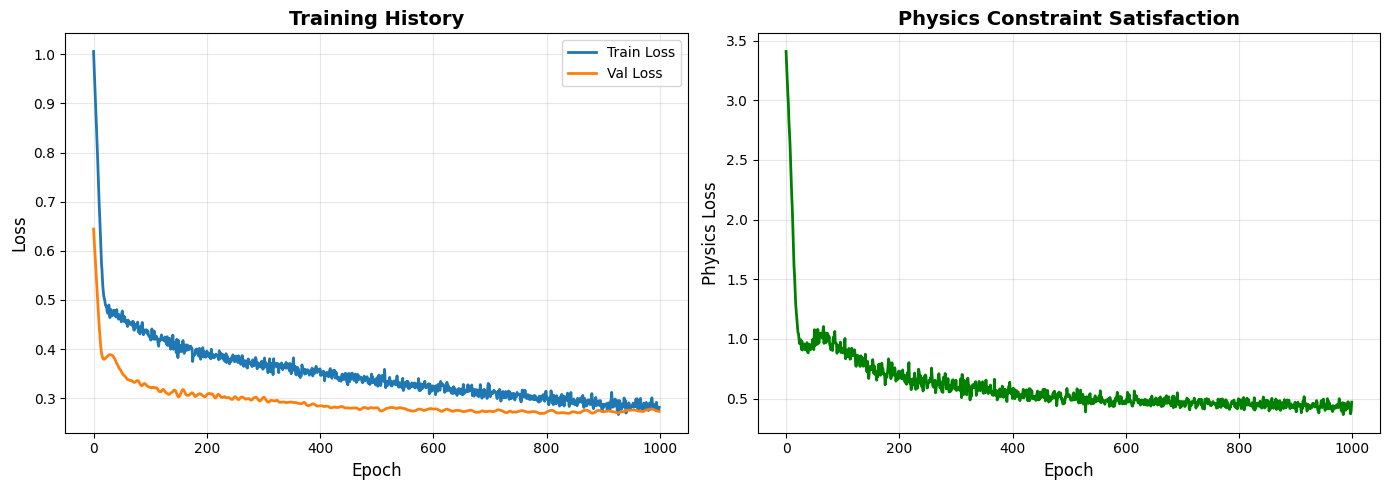


Step 7: Analyzing results...

PINN Performance Metrics
Accuracy    : 0.8491
Precision   : 0.5769
Recall      : 0.2727
F1-Score    : 0.3704
ROC-AUC     : 0.8414


Learned Physical Parameters
Soil Cohesion (c'):           0.0032
Friction Angle (φ'):          29.31°
Pore Pressure Factor (r_u):   -0.0920

Physical Interpretation:
  • Cohesion represents soil binding strength
  • Friction angle controls shear resistance
  • Pore pressure factor indicates water influence



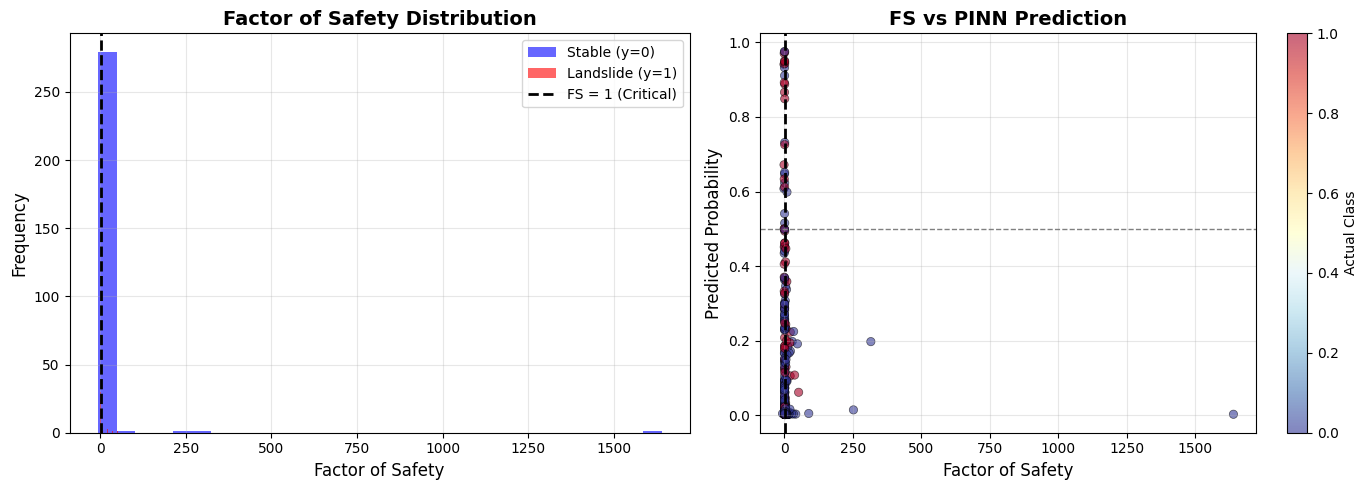

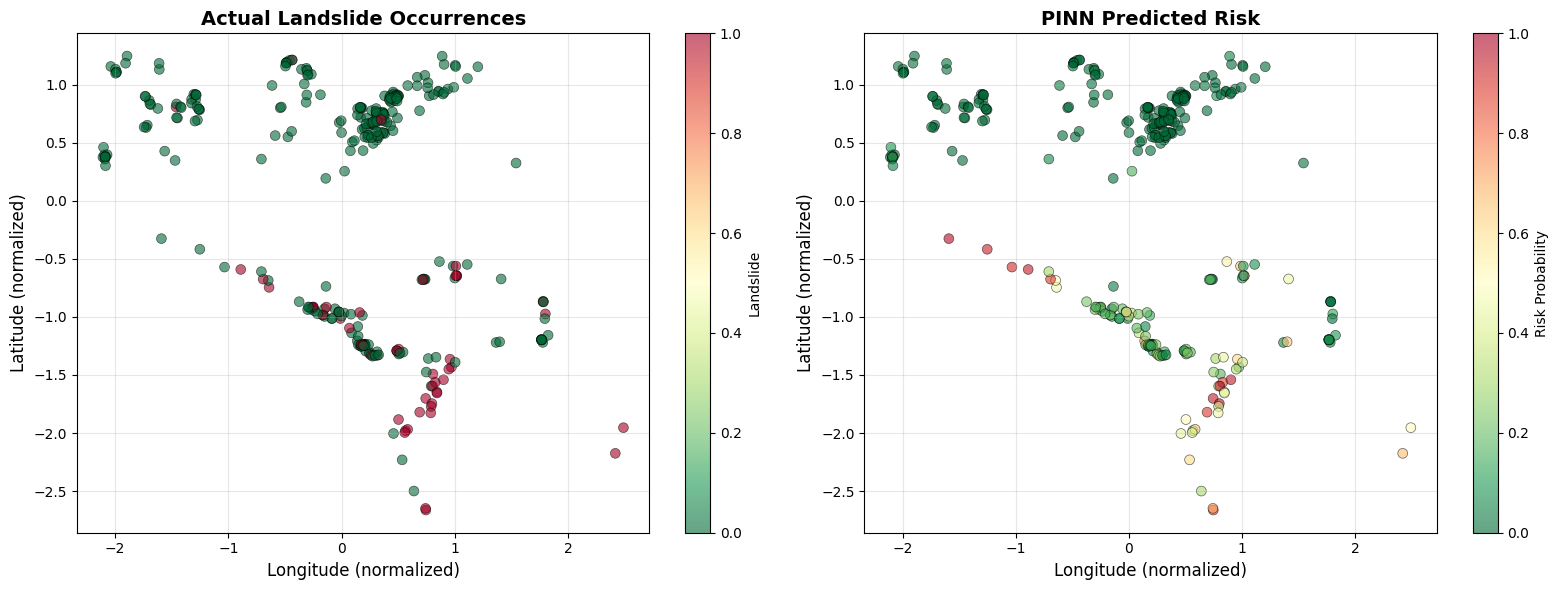


Analysis Complete!


In [4]:
"""
Physics-Informed Neural Networks for Landslide Susceptibility Analysis
Incorporates physical laws of slope stability into neural network training
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# =====================================================
# PART 1: Data Loading and Preprocessing
# =====================================================

class LandslideDataProcessor:
    """Process and engineer features from landslide catalog"""
    
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)
        self.scaler = StandardScaler()
        
    def process(self):
        """Complete preprocessing pipeline"""
        df = self.df.copy()
        
        # 1. Parse dates
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day_of_year'] = df['date'].dt.dayofyear
        
        # 2. Extract coordinates from geolocation tuple
        df[['lat_extracted', 'lon_extracted']] = df['geolocation'].str.extract(
            r'\(([-\d.]+),\s*([-\d.]+)\)'
        ).astype(float)
        
        # Use extracted if original is missing
        df['latitude'] = df['latitude'].fillna(df['lat_extracted'])
        df['longitude'] = df['longitude'].fillna(df['lon_extracted'])
        
        # 3. Create physics-relevant features
        # Slope proxy from latitude (simplified - real would need DEM)
        df['slope_proxy'] = np.abs(df['latitude'] - df['latitude'].mean())
        
        # Seasonal rainfall proxy
        df['rainfall_season'] = np.sin(2 * np.pi * df['month'] / 12)
        
        # Population density proxy
        df['pop_density'] = np.log1p(df['population'].fillna(0))
        
        # 4. Encode categorical variables
        df['trigger_encoded'] = pd.Categorical(df['trigger']).codes
        df['landslide_size_encoded'] = pd.Categorical(df['landslide_size']).codes
        
        # 5. Create target variable (severity)
        df['severity'] = (
            df['fatalities'].fillna(0) * 2 + 
            df['injuries'].fillna(0)
        )
        df['has_casualties'] = (df['severity'] > 0).astype(int)
        
        # 6. Remove rows with missing critical data
        required_cols = ['latitude', 'longitude', 'year']
        df = df.dropna(subset=required_cols)
        
        self.processed_df = df
        return df
    
    def prepare_features(self, target_col='has_casualties'):
        """Prepare feature matrix and target for PINN"""
        
        feature_cols = [
            'latitude', 'longitude', 'slope_proxy', 
            'rainfall_season', 'pop_density', 'day_of_year',
            'trigger_encoded', 'landslide_size_encoded'
        ]
        
        df = self.processed_df.dropna(subset=feature_cols + [target_col])
        
        X = df[feature_cols].values
        y = df[target_col].values
        
        # Normalize features
        X_scaled = self.scaler.fit_transform(X)
        
        return X_scaled, y, feature_cols


# =====================================================
# PART 2: Physics-Informed Neural Network Architecture
# =====================================================

class PhysicsInformedNN(nn.Module):
    """
    PINN that incorporates slope stability physics
    
    Physical constraints:
    1. Factor of Safety (FS) = Resisting Forces / Driving Forces
    2. Mohr-Coulomb failure criterion
    3. Effective stress principle with pore pressure
    """
    
    def __init__(self, input_dim, hidden_dims=[64, 128, 64, 32]):
        super(PhysicsInformedNN, self).__init__()
        
        # Neural network layers
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.Tanh())  # Tanh for smoother gradients
            layers.append(nn.Dropout(0.2))
            prev_dim = hidden_dim
        
        # Output layer (probability of landslide)
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
        
        # Physics parameters (learnable)
        self.cohesion = nn.Parameter(torch.tensor([0.5]))  # Soil cohesion
        self.friction_angle = nn.Parameter(torch.tensor([30.0]))  # degrees
        self.pore_pressure_factor = nn.Parameter(torch.tensor([0.3]))
        
    def forward(self, x):
        """Standard forward pass"""
        return self.network(x)
    
    def compute_factor_of_safety(self, x):
        """
        Compute Factor of Safety based on simplified infinite slope model
        
        FS = (c' + (γ·z·cos²β - u)·tan(φ')) / (γ·z·sinβ·cosβ)
        
        Where:
        - c': effective cohesion
        - φ': effective friction angle
        - β: slope angle
        - u: pore water pressure
        - γ: unit weight of soil
        - z: depth
        """
        # Extract relevant features (normalized)
        # Assuming: [lat, lon, slope_proxy, rainfall, pop_density, day_of_year, ...]
        slope = torch.abs(x[:, 2:3])  # slope_proxy
        rainfall = x[:, 3:4]  # rainfall_season
        
        # Convert friction angle to radians
        phi_rad = self.friction_angle * np.pi / 180
        
        # Simplified slope angle (0-45 degrees)
        beta = slope * np.pi / 4
        
        # Pore pressure increases with rainfall
        pore_pressure = self.pore_pressure_factor * (1 + rainfall)
        
        # Resisting forces
        normal_stress = torch.cos(beta) ** 2
        effective_stress = normal_stress - pore_pressure
        resisting = self.cohesion + effective_stress * torch.tan(phi_rad)
        
        # Driving forces
        driving = torch.sin(beta) * torch.cos(beta)
        
        # Factor of Safety
        fs = resisting / (driving + 1e-6)  # Add epsilon to avoid division by zero
        
        return fs
    
    def physics_loss(self, x, y_pred):
        """
        Physics-based loss that penalizes violations of stability principles
        
        Loss components:
        1. FS should be < 1 for landslides (y=1)
        2. FS should be > 1 for stable slopes (y=0)
        """
        fs = self.compute_factor_of_safety(x)
        
        # For predicted landslides, FS should be less than 1
        landslide_penalty = torch.mean(torch.relu(fs - 1.0) * y_pred)
        
        # For predicted stable areas, FS should be greater than 1
        stable_penalty = torch.mean(torch.relu(1.0 - fs) * (1 - y_pred))
        
        # Total physics loss
        physics_loss = landslide_penalty + stable_penalty
        
        return physics_loss


# =====================================================
# PART 3: Training with Physics-Informed Loss
# =====================================================

class PINNTrainer:
    """Train PINN with combined data and physics loss"""
    
    def __init__(self, model, lambda_physics=0.1):
        self.model = model
        self.lambda_physics = lambda_physics  # Weight for physics loss
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        self.bce_loss = nn.BCELoss()
        
        self.train_losses = []
        self.val_losses = []
        self.physics_losses = []
        
    def train_epoch(self, X_train, y_train):
        """Single training epoch"""
        self.model.train()
        
        # Convert to tensors
        X_tensor = torch.FloatTensor(X_train)
        y_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
        
        # Forward pass
        y_pred = self.model(X_tensor)
        
        # Data loss (Binary Cross-Entropy)
        data_loss = self.bce_loss(y_pred, y_tensor)
        
        # Physics loss
        physics_loss = self.model.physics_loss(X_tensor, y_pred)
        
        # Combined loss
        total_loss = data_loss + self.lambda_physics * physics_loss
        
        # Backward pass
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        
        return total_loss.item(), data_loss.item(), physics_loss.item()
    
    def validate(self, X_val, y_val):
        """Validation step"""
        self.model.eval()
        
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_val)
            y_tensor = torch.FloatTensor(y_val).reshape(-1, 1)
            
            y_pred = self.model(X_tensor)
            val_loss = self.bce_loss(y_pred, y_tensor)
            
        return val_loss.item()
    
    def train(self, X_train, y_train, X_val, y_val, epochs=1000):
        """Complete training loop"""
        print("Training Physics-Informed Neural Network...\n")
        
        for epoch in range(epochs):
            train_loss, data_loss, phys_loss = self.train_epoch(X_train, y_train)
            val_loss = self.validate(X_val, y_val)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.physics_losses.append(phys_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}")
                print(f"  Train Loss: {train_loss:.4f} (Data: {data_loss:.4f}, Physics: {phys_loss:.4f})")
                print(f"  Val Loss: {val_loss:.4f}")
                print(f"  Learned Parameters:")
                print(f"    Cohesion: {self.model.cohesion.item():.3f}")
                print(f"    Friction Angle: {self.model.friction_angle.item():.1f}°")
                print(f"    Pore Pressure Factor: {self.model.pore_pressure_factor.item():.3f}\n")
    
    def plot_training_history(self):
        """Visualize training progress"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Loss curves
        axes[0].plot(self.train_losses, label='Train Loss', linewidth=2)
        axes[0].plot(self.val_losses, label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].set_title('Training History', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        
        # Physics loss
        axes[1].plot(self.physics_losses, color='green', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Physics Loss', fontsize=12)
        axes[1].set_title('Physics Constraint Satisfaction', fontsize=14, fontweight='bold')
        axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# =====================================================
# PART 4: Analysis and Visualization
# =====================================================

class PINNAnalyzer:
    """Analyze PINN predictions and physics parameters"""
    
    def __init__(self, model, X_test, y_test, feature_names):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.feature_names = feature_names
        
    def predict(self):
        """Get predictions"""
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(self.X_test)
            self.y_pred = self.model(X_tensor).numpy().flatten()
            self.y_pred_binary = (self.y_pred > 0.5).astype(int)
    
    def compute_metrics(self):
        """Calculate performance metrics"""
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        
        metrics = {
            'Accuracy': accuracy_score(self.y_test, self.y_pred_binary),
            'Precision': precision_score(self.y_test, self.y_pred_binary, zero_division=0),
            'Recall': recall_score(self.y_test, self.y_pred_binary, zero_division=0),
            'F1-Score': f1_score(self.y_test, self.y_pred_binary, zero_division=0),
            'ROC-AUC': roc_auc_score(self.y_test, self.y_pred)
        }
        
        print("\n" + "="*50)
        print("PINN Performance Metrics")
        print("="*50)
        for metric, value in metrics.items():
            print(f"{metric:12s}: {value:.4f}")
        print("="*50 + "\n")
        
        return metrics
    
    def plot_factor_of_safety_distribution(self):
        """Visualize Factor of Safety for test samples"""
        with torch.no_grad():
            X_tensor = torch.FloatTensor(self.X_test)
            fs = self.model.compute_factor_of_safety(X_tensor).numpy().flatten()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # FS distribution by actual class
        axes[0].hist(fs[self.y_test == 0], bins=30, alpha=0.6, label='Stable (y=0)', color='blue')
        axes[0].hist(fs[self.y_test == 1], bins=30, alpha=0.6, label='Landslide (y=1)', color='red')
        axes[0].axvline(1.0, color='black', linestyle='--', linewidth=2, label='FS = 1 (Critical)')
        axes[0].set_xlabel('Factor of Safety', fontsize=12)
        axes[0].set_ylabel('Frequency', fontsize=12)
        axes[0].set_title('Factor of Safety Distribution', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        
        # Scatter: FS vs Prediction
        scatter = axes[1].scatter(fs, self.y_pred, c=self.y_test, cmap='RdYlBu_r', 
                                   alpha=0.6, edgecolors='k', linewidths=0.5)
        axes[1].axvline(1.0, color='black', linestyle='--', linewidth=2)
        axes[1].axhline(0.5, color='gray', linestyle='--', linewidth=1)
        axes[1].set_xlabel('Factor of Safety', fontsize=12)
        axes[1].set_ylabel('Predicted Probability', fontsize=12)
        axes[1].set_title('FS vs PINN Prediction', fontsize=14, fontweight='bold')
        axes[1].grid(alpha=0.3)
        plt.colorbar(scatter, ax=axes[1], label='Actual Class')
        
        plt.tight_layout()
        plt.show()
    
    def plot_spatial_risk_map(self):
        """Create spatial risk map using lat/lon"""
        # Extract lat/lon (indices 0, 1)
        lats = self.X_test[:, 0]
        lons = self.X_test[:, 1]
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Actual landslides
        scatter1 = axes[0].scatter(lons, lats, c=self.y_test, cmap='RdYlGn_r',
                                    s=50, alpha=0.6, edgecolors='k', linewidths=0.5)
        axes[0].set_xlabel('Longitude (normalized)', fontsize=12)
        axes[0].set_ylabel('Latitude (normalized)', fontsize=12)
        axes[0].set_title('Actual Landslide Occurrences', fontsize=14, fontweight='bold')
        plt.colorbar(scatter1, ax=axes[0], label='Landslide')
        axes[0].grid(alpha=0.3)
        
        # Predicted risk
        scatter2 = axes[1].scatter(lons, lats, c=self.y_pred, cmap='RdYlGn_r',
                                    s=50, alpha=0.6, edgecolors='k', linewidths=0.5, vmin=0, vmax=1)
        axes[1].set_xlabel('Longitude (normalized)', fontsize=12)
        axes[1].set_ylabel('Latitude (normalized)', fontsize=12)
        axes[1].set_title('PINN Predicted Risk', fontsize=14, fontweight='bold')
        plt.colorbar(scatter2, ax=axes[1], label='Risk Probability')
        axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_physics_parameters(self):
        """Display learned physics parameters"""
        print("\n" + "="*50)
        print("Learned Physical Parameters")
        print("="*50)
        print(f"Soil Cohesion (c'):           {self.model.cohesion.item():.4f}")
        print(f"Friction Angle (φ'):          {self.model.friction_angle.item():.2f}°")
        print(f"Pore Pressure Factor (r_u):   {self.model.pore_pressure_factor.item():.4f}")
        print("="*50)
        print("\nPhysical Interpretation:")
        print(f"  • Cohesion represents soil binding strength")
        print(f"  • Friction angle controls shear resistance")
        print(f"  • Pore pressure factor indicates water influence")
        print("="*50 + "\n")


# =====================================================
# PART 5: Main Execution Pipeline
# =====================================================

def main(filepath='catalog.csv'):
    """Complete PINN analysis pipeline"""
    
    print("="*60)
    print("PHYSICS-INFORMED NEURAL NETWORK FOR LANDSLIDE ANALYSIS")
    print("="*60 + "\n")
    
    # 1. Load and process data
    print("Step 1: Loading and processing data...")
    processor = LandslideDataProcessor(filepath)
    df_processed = processor.process()
    print(f"  ✓ Processed {len(df_processed)} landslide events\n")
    
    # 2. Prepare features
    print("Step 2: Preparing features...")
    X, y, feature_names = processor.prepare_features()
    print(f"  ✓ Feature matrix: {X.shape}")
    print(f"  ✓ Target distribution: {np.bincount(y)}\n")
    
    # 3. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"Step 3: Data split")
    print(f"  ✓ Train: {X_train.shape[0]} samples")
    print(f"  ✓ Val:   {X_val.shape[0]} samples")
    print(f"  ✓ Test:  {X_test.shape[0]} samples\n")
    
    # 4. Initialize PINN
    print("Step 4: Initializing Physics-Informed Neural Network...")
    model = PhysicsInformedNN(input_dim=X.shape[1])
    print(f"  ✓ Model architecture: {sum(p.numel() for p in model.parameters())} parameters\n")
    
    # 5. Train PINN
    print("Step 5: Training...\n")
    trainer = PINNTrainer(model, lambda_physics=0.1)
    trainer.train(X_train, y_train, X_val, y_val, epochs=1000)
    
    # 6. Visualize training
    print("\nStep 6: Visualizing training history...")
    trainer.plot_training_history()
    
    # 7. Analyze results
    print("\nStep 7: Analyzing results...")
    analyzer = PINNAnalyzer(model, X_test, y_test, feature_names)
    analyzer.predict()
    analyzer.compute_metrics()
    analyzer.analyze_physics_parameters()
    analyzer.plot_factor_of_safety_distribution()
    analyzer.plot_spatial_risk_map()
    
    print("\n" + "="*60)
    print("Analysis Complete!")
    print("="*60)
    
    return model, analyzer


# Run the analysis
if __name__ == "__main__":
    # Use your catalog.csv file path
    model, analyzer = main('catalog.csv')